In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from bikes.preprocess.preprocess import get_tensor_train_dataset, Scaler
from bikes.evaluate.split import train_test_split, TEST_PERIOD

/Users/lukasmalms/faculty/sequence-learners/bikes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
def plot_timeseries(actual: pd.Series, predicted: pd.Series):
    fig, ax = plt.subplots()

    ax.plot(actual, label="Observed")
    ax.plot(predicted, label="Predicted")

    ax.set(ylabel="Count")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend()

    fig.tight_layout();

    return ax

## RNN

In [4]:
class RnnForecaster(nn.Module):
    def __init__(self,  horizon: int, input_size: int = 1, hidden_size: int = 25, num_layers: int =1):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.ho = nn.Linear(in_features=hidden_size, out_features=horizon)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out_, _ = self.rnn(x)
        return self.ho(out_)

In [5]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["date"])

In [6]:
LOCATION = "Dominion Road"

location_df = cycle_counts.loc[cycle_counts["location"] == LOCATION].copy()
location_df = location_df.set_index("date").sort_index()
train_df, test_df = train_test_split(location_df)
y, y_test = train_df["count"], test_df["count"]

In [7]:
# Prepare data
scaler = Scaler()
y_train_scaled = scaler.fit_transform(y)

test_start, test_end = TEST_PERIOD
test_dates = pd.date_range(test_start, test_end, freq="D", inclusive="left")

out_seq_length = len(test_dates)
in_seq_length = 6 * out_seq_length
ts = get_tensor_train_dataset(y_train_scaled, in_seq_length=in_seq_length, out_seq_length=out_seq_length)
dataloader = DataLoader(ts, batch_size=32)

In [ ]:
# Training loop
model = RnnForecaster(horizon=out_seq_length)

loss_fn = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-03)

model.train()
iteration_loss = []
n_epochs = 100
pgbar = tqdm(range(100))
for epoch in pgbar:
    for X, y in dataloader:
        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y, y_hat)
        loss.backward()
        optimizer.step()
    iteration_loss.append(float(loss.detach()))
    pgbar.set_description(f"Epoch [{epoch + 1} / {n_epochs}] - Loss = {loss:.3f}")

Epoch [99 / 100]: Loss = 0.474: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


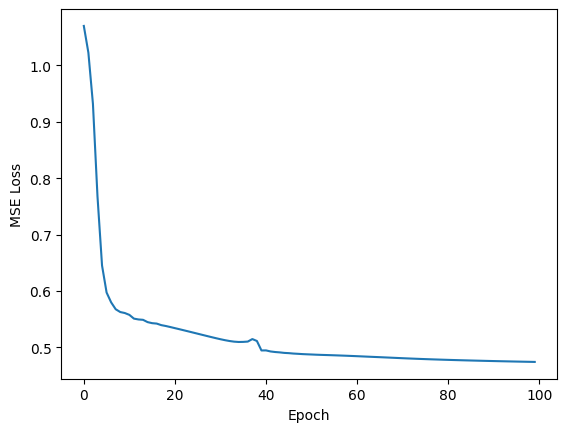

In [10]:
plt.plot(iteration_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss");

In [ ]:
# Forecast
